# 1. Introduction: Predicting Glacier Ice Quantity Using Machine Learning

## Context

Greenland's dynamic cryosphere has a profound influence on global sea levels and regional climatic systems. Monitoring and understanding glacier activity is pivotal for assessing the impacts of climate change. One promising approach leverages infrasonic signals—low-frequency acoustic waves generated by glacier-related processes such as calving events and meltwater discharge. Recent studies, including long-term monitoring near Greenland's Qaanaaq glacier, demonstrate strong correlations between infrasound activity and environmental variables like atmospheric temperature and sea surface conditions​(Geophysical_Research ...).

In this study, we focus on a specific task: building a predictive model to evaluate glacier ice conditions at a given location using infrasound recordings. The problem is framed as a binary classification, where we predict whether the ice quantity is "low" or "high" based on climate, sea ice concentration, and infrasound features.

## Objective

The main goal is to develop a reliable machine learning classifier to predict the binary state of glacier ice quantity (high or low) by analyzing infrasound signals and climate data. We aim to:

- Preprocess and transform raw data into usable formats.
- Train and compare multiple machine learning classifiers.
- Identify the most effective model based on evaluation metrics.
- Derive insights into the relationships between predictor variables and ice quantity.

## Hypothesis

We hypothesize that variations in infrasound signals and associated climate variables are predictive of glacier ice states. Specifically:

High infrasonic activity correlates with low ice quantity due to calving or discharge events.
Environmental variables such as temperature and wind speed enhance the predictive power of infrasonic features.

## Approach

To achieve the study's objectives, we propose the following structured methodology:

- Data Acquisition and Preparation: Load and clean the dataset, including infrasound and climate features. Transform the quantitative target variable into a binary classification based on a chosen threshold.
- Exploratory Data Analysis (EDA): Examine the distribution of features and assess their relationship with the target variable.
- Modeling:
Train various binary classifiers such as Logistic Regression, Support Vector Machines (SVM), Random Forests, and Gradient Boosting models.
Use k-fold cross-validation for robust model evaluation.
- Performance Comparison: Evaluate models using metrics like accuracy, precision, recall, F1-score, and AUC-ROC.
- Feature Importance Analysis: Identify key variables contributing to model predictions to understand the underlying dynamics.
- Conclusions and Recommendations: Discuss the best-performing model, its potential applications, and areas for future research.


# Import the data (features and targets)

In [1]:
# Ajouter le dossier `src` au chemin de recherche Python
import sys
import os
sys.path.append(os.path.abspath('../src'))

# Importer la fonction `load_data` depuis le module `preprocess` dans `data_processing`
from data_processing.preprocessing import *
from utils.plotting import *
from utils.pca import *
from model.random_forest import *
from model.bagging import *
from model.adaboost import *
from model.metrics import *
from utils.tuning import *

features_path = '../data/raw/data_Features.csv'
target_path = '../data/raw/data_Targets.csv'

# Charger les données
features, targets = load_data(features_path, target_path)
X = features
Y = targets['Y1']

# 2. Exploratory Data analysis

In [2]:
# Call the function to describe the data
describe_data(X, Y)

Features Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556 entries, 0 to 2555
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    2556 non-null   object 
 1   t2m     2556 non-null   float64
 2   u10     2556 non-null   float64
 3   v10     2556 non-null   float64
 4   SST     2556 non-null   float64
 5   SIC     2556 non-null   float64
 6   r1_MAR  2556 non-null   float64
 7   r2_MAR  2556 non-null   float64
 8   r3_MAR  2556 non-null   float64
 9   r4_MAR  2556 non-null   float64
 10  r5_MAR  2556 non-null   float64
dtypes: float64(10), object(1)
memory usage: 219.8+ KB
None

Basic Statistics for Features:
               t2m          u10          v10          SST          SIC  \
count  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000   
mean    -10.190040     0.139648     0.626351    -0.858922    73.267808   
std      10.340583     5.013640     3.955417     1.446165    29.250724   
m

### Features Dataset

**No missing values**: All features are complete, which simplifies preprocessing.

**Data types**: All features except time are numeric. The time column should be converted to a datetime format if time-based trends are to be analyzed.

**Distributions**:

Variables such as t2m (temperature), SST (sea surface temperature), and wind components (u10, v10) show reasonable ranges for Arctic conditions.
SIC (sea ice concentration) is bounded between 0 and 100, consistent with its nature as a percentage.
r1_MAR to r5_MAR (discharge data) contain many zeros, suggesting periods of no activity.

**High variance in some variables**: Especially r1_MAR and r2_MAR, which may indicate outliers or heavy-tailed distributions.
### Target Dataset (Y1)

**Highly imbalanced**:
The median is 0, with 75% of values also being 0. This indicates that most samples have no significant signal in Y1.

**Outliers in Y1**: The maximum value is 433, significantly larger than the mean (3.53), indicating potential outliers.

In [3]:
# We choose to drop the time
X = X.drop(columns=['time'])

# visualize patterns, balance, and transformations required

## Visualize Target Distribution

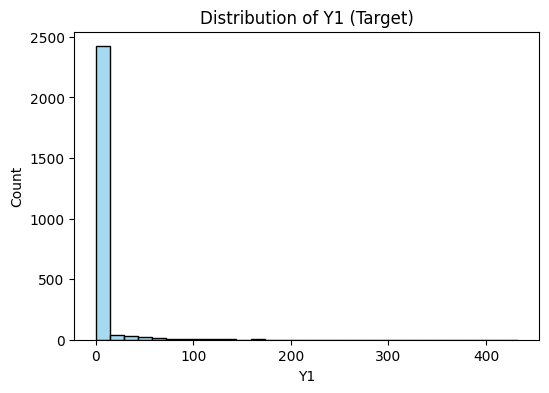

In [4]:
plot_target_distribution(Y)

The histogram of Y1 (target variable) indicates that the data is highly imbalanced, with the majority of values being near zero. This imbalance will need to be addressed to ensure fair model performance.

## Correlation HeatMap

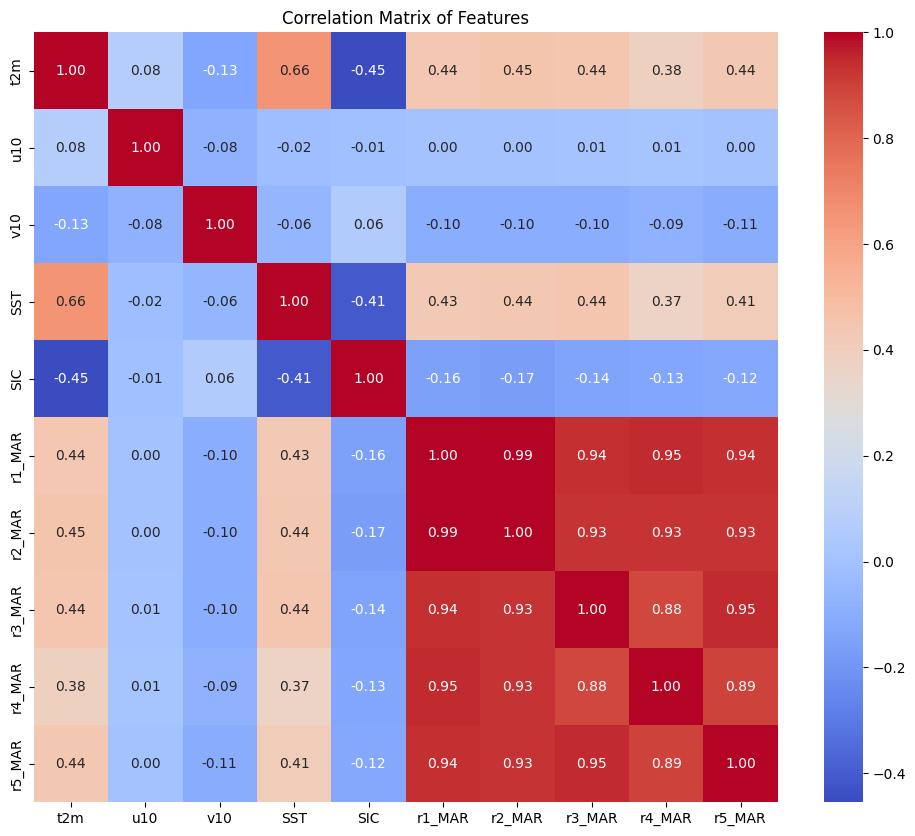

In [5]:
plot_correlation_heatmap(X)

Since r1_MAR to r5_MAR are highly correlated, we are going to  use Principal Component Analysis (PCA) to combine them into fewer components.
## Correlation with our target Y1

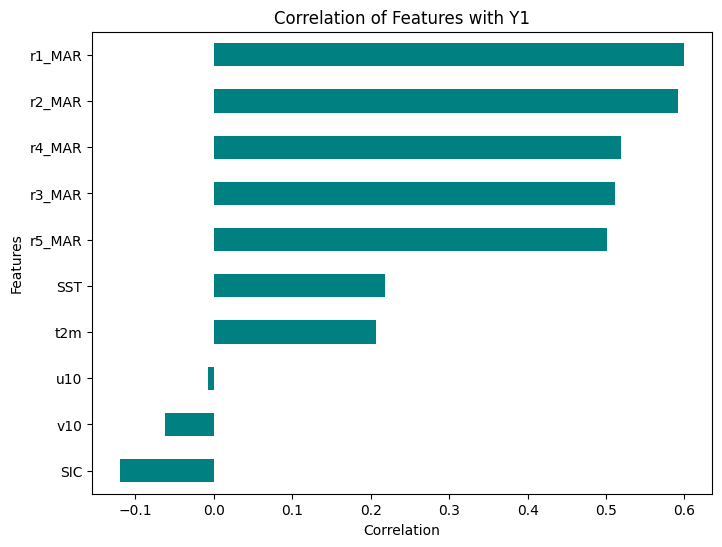

In [6]:
plot_feature_target_correlation(X, Y)

### Observations:

1. **Strongly Correlated Features:**
   - The `r1_MAR`, `r2_MAR`, `r3_MAR`, `r4_MAR`, and `r5_MAR` variables exhibit the highest positive correlation with `Y1` (around 0.5 to 0.6). This aligns with the earlier correlation matrix, indicating that these features are highly relevant for predicting `Y1`.

2. **Moderately Correlated Features:**
   - `SST` and `t2m` (Sea Surface Temperature and temperature at 2 meters, respectively) show moderate positive correlations (~0.3). These features are also important but might require interaction with other features to improve their predictive value.

3. **Weak or Negligible Correlation:**
   - Features like `u10` and `v10` (wind components) and `SIC` (Sea Ice Concentration) exhibit weak correlations with `Y1`. These features might contribute less directly to predictions.

## Features distributions

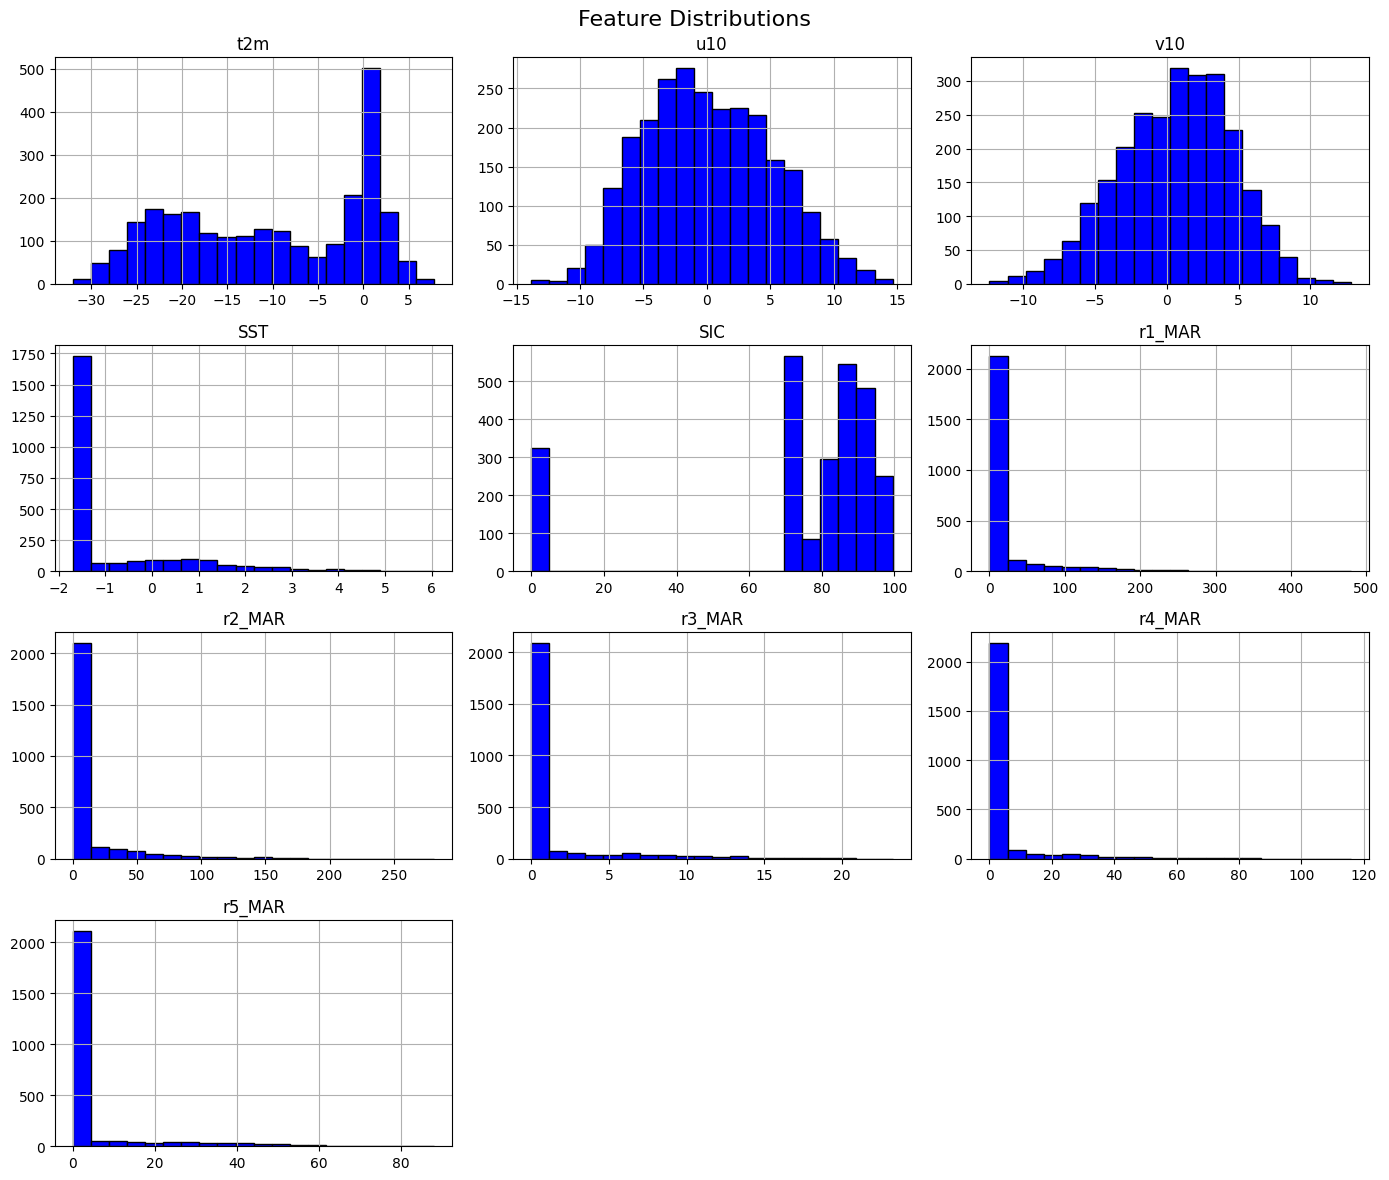

In [7]:
plot_feature_distributions(X)

### Observations:

1. **`t2m` (Temperature):**
   - Appears to be bimodal, with most values clustering around -10°C and another smaller cluster around 0°C.
   - This could indicate seasonal or regional effects, which might warrant additional analysis.

2. **`u10` and `v10` (Wind Components):**
   - Both features are approximately symmetric and centered around 0, indicating a balanced distribution of wind speeds and directions.
   - These features likely do not need much preprocessing, aside from potential scaling.

3. **`SST` (Sea Surface Temperature):**
   - Positively skewed, with most values below 0 and a long tail toward higher temperatures.
   - This feature might benefit from a logarithmic transformation to reduce skewness and stabilize variance.

4. **`SIC` (Sea Ice Concentration):**
   - Bimodal, with two clusters near 0% and 100%. This likely reflects regions with no ice and regions fully covered by ice.
   - The bimodal nature could have a significant impact on predictive modeling and should be preserved.

5. **`r1_MAR` to `r5_MAR` (Discharge Variables):**
   - Extremely skewed, with most values close to 0 and a few very large values.
   - This suggests that discharge events are rare but significant when they occur.
   - A logarithmic or Box-Cox transformation might help normalize these features.

## Features vs Y1


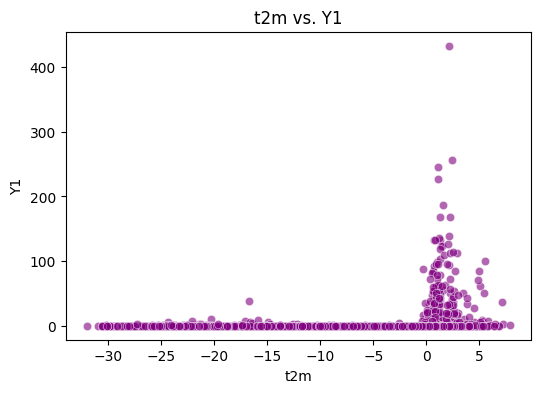

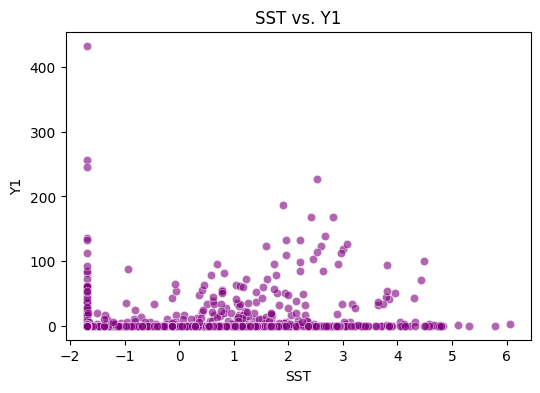

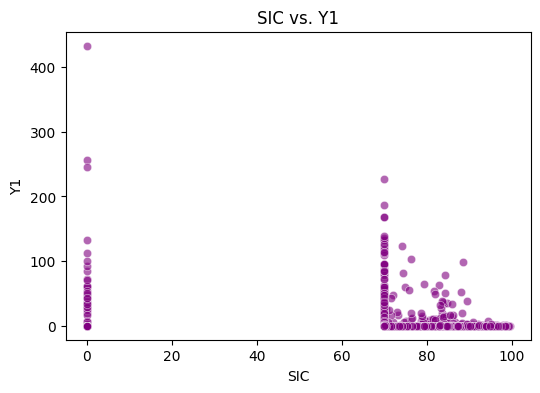

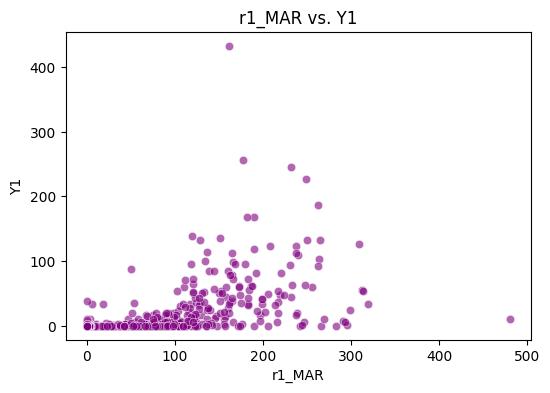

In [8]:
# Scatter plot for some key features against Y1
key_features = ['t2m', 'SST', 'SIC', 'r1_MAR']  # Adjust this list as needed
plot_feature_target_relationship(X, Y, key_features)

### Observations:

**Non-linear Relationship**:

At lower temperatures (below -10°C), Y1 values are consistently near zero, indicating little or no activity in Y1 during colder conditions.

As temperatures approach 0°C and above, Y1 values increase significantly, suggesting a stronger relationship between warmer temperatures and Y1.

**Clustered Activity**:

Most higher values of Y1 are concentrated in a narrow range of t2m between -5°C and 5°C.

There are a few extreme values (outliers) for Y1 when t2m is slightly positive.

**Threshold Behavior**:

This pattern suggests a potential threshold effect, where Y1 becomes significant only when t2m crosses a certain value (e.g., -5°C).

# 3. Preprocessing

**Target variable Y1** : The distribution shows a majority of values around 0 (strong asymmetry), but extreme values (>400) can bias the models. But, our goal will be to keep the maximum of 1 in our model to maximise the recall.  

In [9]:
y1_percentiles = Y.quantile([0.88, 0.89, 0.90])
print("88th, 89th, 90th Percentiles:\n", y1_percentiles)

88th, 89th, 90th Percentiles:
 0.88    0.0
0.89    1.0
0.90    1.0
Name: Y1, dtype: float64


We will choose the value 1 as a threshold with the purpose to have the maximum of 1 in our binary variable Y_binary 

In [10]:
Y_binary = transform_target_to_binary(Y, 1)

Since `r1_MAR` to `r5_MAR` are highly correlated, we are going to  use Principal Component Analysis (PCA) to combine them into fewer components.

In [11]:
# Liste des colonnes MAR
mar_columns = ['r1_MAR', 'r2_MAR', 'r3_MAR', 'r4_MAR', 'r5_MAR']

# Appliquer PCA
X, explained_variance = apply_pca_to_mar_features(features, mar_columns)
X = X.drop(columns=mar_columns)

# Afficher la variance expliquée
print(f"Variance expliquée par la première composante : {explained_variance:.2%}")

Variance expliquée par la première composante : 94.57%


In [12]:
print(X.head())


         time        t2m       u10       v10       SST        SIC  r_MAR_pca
0  2013-01-01 -21.926931 -0.973994  3.149094 -1.690511  90.745710  -0.859688
1  2013-01-02 -23.696195 -6.502908  2.494894 -1.690511  88.502980  -0.859689
2  2013-01-03 -25.644027 -3.557411  1.025486 -1.689860  88.734091  -0.859689
3  2013-01-04 -23.566887 -1.888075 -3.486122 -1.690511  89.149576  -0.859689
4  2013-01-05 -22.897768 -2.748844 -3.491206 -1.689860  91.613955  -0.859690


## Normalisation and standardisation

In [13]:
# Appliquer les transformations sur le DataFrame des features
X = preprocess_features(X)

# Vérifier les transformations
print(X.head())

        t2m       u10       v10  r_MAR_pca   SST_log  SIC_scaled
0 -1.135254 -0.222166  0.637919  -0.859688  0.694122    0.912011
1 -1.306386 -1.325156  0.472493  -0.859689  0.694122    0.889471
2 -1.494791 -0.737544  0.100928  -0.859689  0.694447    0.891794
3 -1.293879 -0.404520 -1.039910  -0.859689  0.694122    0.895970
4 -1.229158 -0.576239 -1.041195  -0.859690  0.694447    0.920737


### Explanation of Data Transformations

In the preprocessing step, several transformations were applied to the dataset to prepare the features for modeling. These transformations aim to ensure the data is appropriately scaled, meaningful, and ready for use in machine learning algorithms. Below is a summary of the transformations applied to the variables and the reasons behind each choice:

1. **Dropping the `time` column**:
   - The `time` column is removed as it does not provide meaningful information for predictive modeling in its raw form. Temporal features may be engineered separately if necessary.

2. **Standardization of `t2m` (temperature), `u10`, and `v10` (wind components)**:
   - These variables have varying scales and distributions. Standardization was applied to center them around 0 with a standard deviation of 1. This transformation ensures that models sensitive to variable magnitudes, such as Support Vector Machines or PCA, perform optimally.

3. **Logarithmic transformation of `SST` (Sea Surface Temperature)**:
   - The `SST` variable contains a skewed distribution with potential negative values. To stabilize variance and reduce the impact of extreme values, a logarithmic transformation was applied after shifting negative values to make them non-negative. This helps models better capture relationships involving `SST`.

4. **Normalization of `SIC` (Sea Ice Concentration)**:
   - The `SIC` variable is naturally bounded between 0 and 100, representing a percentage. Normalization was applied to scale this feature to a range of [0, 1], preserving its relative magnitude while aligning it with other normalized features.

5. **Dimensionality reduction of `r1_MAR` to `r5_MAR` (discharge-related variables)**:
   - These variables are highly correlated and contribute redundant information. PCA (Principal Component Analysis) was applied to reduce these five variables into a single component, `r_MAR_pca`, which captures the majority of the variance in the original variables. This step reduces dimensionality while preserving information.

These transformations ensure that all features are prepared for machine learning by addressing scale differences, skewness, redundancy, and interpretability. This preprocessing improves the efficiency and accuracy of downstream models.

# **4. Definition of the Target and Problem**

## **Objective**:
The aim of this project is to develop a machine learning model to predict and analyze the behavior of a dependent variable (`Y1`) based on the provided features. The following aspects clarify the problem type, target transformation, and evaluation metrics.

---

## **Problem Type**:
- **Supervised Learning**:
  - This is a **supervised problem** where the target variable (`Y1`) is known and labeled for all observations. 
  - Based on the nature of the target and the problem requirements, we approach it as a **classification** or **regression task**, depending on the specific modeling stage.

- **Classification**:
  - If `Y1` is transformed into a binary target, the task becomes **classification**, where the goal is to predict whether the target represents a "low" or "high" state based on a defined threshold.


## **Target Transformation**:
To enhance the model's focus and interpretability, we applied the following transformation to `Y1`:

**Binarization**:
   - A threshold of **1.0** was applied to convert the target variable into binary categories:
     - `0`: Low or no activity (`Y1 < 1.0`).
     - `1`: High activity (`Y1 >= 1.0`).
   - This transformation simplifies the task to a binary classification problem, enabling the model to focus on distinguishing significant activity from non-significant activity.

## **Evaluation Metrics**:
The following metrics will be used to evaluate model performance:

**For Classification**:

   - **Recall (Sensitivity)**:
     - Prioritized to minimize false negatives, ensuring that most significant cases (`Y1 = 1`) are correctly identified.
     - Relevant in scenarios where missing a significant event has a higher cost than false alarms.
   - **F1-Score**:
     - Balances precision and recall, particularly useful for imbalanced datasets where one class dominates.
   - **Area Under the Receiver Operating Characteristic Curve (AUC-ROC)**:
     - Measures the ability of the model to distinguish between the binary classes across different thresholds.



## **Justification of Metrics**:
- **Recall is emphasized** in classification to ensure the model captures as many significant cases as possible, even at the cost of more false positives.
- **F1-Score** balances the need for both precision and recall, making it suitable for evaluating imbalanced datasets.

# 5. Split of our datasets

The datasets `X` and `Y_binary` will be split into training, validation, and testing sets. The `test_size` parameter will determine the proportion of the data allocated to the test set. The `val_size` parameter will be used to reserve a portion of the training data for validation.

The `stratify` parameter is set to `Y_binary` to ensure that the distribution of the target variable (`Y_binary`) is preserved in both the training and testing sets.

If `val_size` is provided, the training set will be further divided into training and validation sets.

In [14]:
# Split des données avec un ensemble de validation
X_train, X_test, y_train, y_test = split_data(X, Y_binary, test_size=0.2)

# Vérifier les tailles des ensembles
print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

Train set: (2044, 6), Test set: (512, 6)


### Check of the proportion

In [15]:
# Distribution des classes dans chaque ensemble
print("Training class distribution:")
print(y_train.value_counts(normalize=True))

print("Test class distribution:")
print(y_test.value_counts(normalize=True))


Training class distribution:
Y1
0    0.909002
1    0.090998
Name: proportion, dtype: float64
Test class distribution:
Y1
0    0.910156
1    0.089844
Name: proportion, dtype: float64


# Modelisation 
## Modelisation using RandomForest

In [40]:
# Train Random Forest
rf_model = train_random_forest(X_train, y_train)

## Modelisation using Bagging 

In [17]:
# Train Bagging
bagging_model = train_bagging(X_train, y_train)

## Modelisation using Adaboost

In [18]:
# Train AdaBoost
adaboost_model = train_adaboost(X_train, y_train)

## Evaluation of the model

In [19]:
# Evaluate Random Forest
rf_eval = evaluate_model(rf_model, X_test, y_test)
print("Random Forest ROC-AUC:", rf_eval["roc_auc"])
print("Random Forest Classification Report:", rf_eval["classification_report"])

# Evaluate Bagging
bagging_eval = evaluate_model(bagging_model, X_test, y_test)
print("Bagging ROC-AUC:", bagging_eval["roc_auc"])
print("Bagging Classification Report:", bagging_eval["classification_report"])

# Evaluate AdaBoost
adaboost_eval = evaluate_model(adaboost_model, X_test, y_test)
print("AdaBoost ROC-AUC:", adaboost_eval["roc_auc"])
print("AdaBoost Classification Report:", adaboost_eval["classification_report"])



Random Forest ROC-AUC: 0.9270153013621945
Random Forest Classification Report: {'0': {'precision': 0.9765957446808511, 'recall': 0.9849785407725322, 'f1-score': 0.9807692307692307, 'support': 466.0}, '1': {'precision': 0.8333333333333334, 'recall': 0.7608695652173914, 'f1-score': 0.7954545454545455, 'support': 46.0}, 'accuracy': 0.96484375, 'macro avg': {'precision': 0.9049645390070922, 'recall': 0.8729240529949618, 'f1-score': 0.8881118881118881, 'support': 512.0}, 'weighted avg': {'precision': 0.9637245124113475, 'recall': 0.96484375, 'f1-score': 0.9641198645104894, 'support': 512.0}}
Bagging ROC-AUC: 0.9273885053181563
Bagging Classification Report: {'0': {'precision': 0.972457627118644, 'recall': 0.9849785407725322, 'f1-score': 0.9786780383795309, 'support': 466.0}, '1': {'precision': 0.825, 'recall': 0.717391304347826, 'f1-score': 0.7674418604651162, 'support': 46.0}, 'accuracy': 0.9609375, 'macro avg': {'precision': 0.898728813559322, 'recall': 0.8511849225601791, 'f1-score': 0.8

## Hyperparameter tuning

A completer 

In [31]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialiser le modèle
rf_model = RandomForestClassifier(random_state=42)

# Optimisation des hyperparamètres
best_rf, best_rf_params = optimize_hyperparameters(
    model=rf_model,
    param_grid=param_grid_rf,
    X_train=X_train,
    y_train=y_train,
    cv=5,
    scoring='recall',  # Utilisez une métrique pertinente
    search_type='grid'
)

# Évaluation directement avec le modèle fitté
print("Best Random Forest Parameters:", best_rf_params)

# Le modèle `best_rf` est déjà entraîné et peut être utilisé directement :
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total ti

## On regarde sur l'ensemble de test

In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       466
           1       0.80      0.78      0.79        46

    accuracy                           0.96       512
   macro avg       0.89      0.88      0.89       512
weighted avg       0.96      0.96      0.96       512



In [33]:
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba_rf):.4f}")

ROC-AUC Score: 0.9457


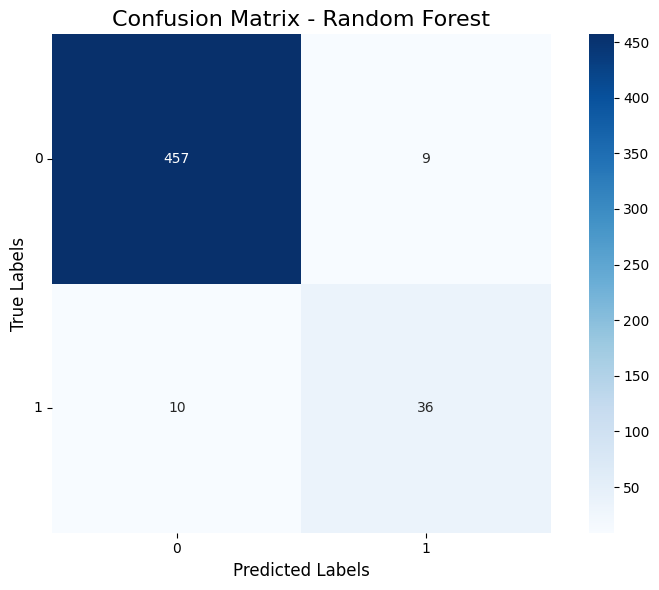

In [ ]:
plot_confusion_matrix(
    y_true=y_test,
    y_pred=y_pred_rf,
    labels=[0, 1],  # Adapter si vous avez plus de classes
    normalize=False,  # Mettre True si vous voulez des proportions
    title="Confusion Matrix - Random Forest"
)

## Confusion Matrix

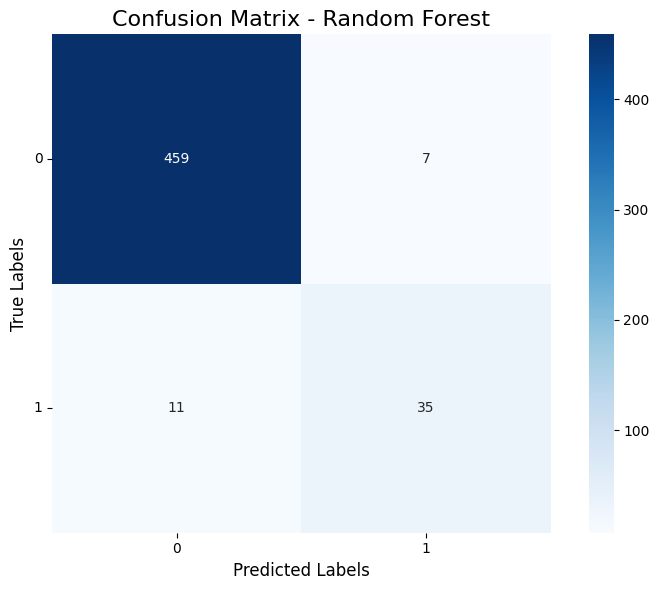

In [41]:
y_pred_randomForest = rf_model.predict(X_test)
rf_conf_matrix = confusion_matrix(y_test, y_pred_randomForest)
plot_confusion_matrix(
    y_true=y_test,
    y_pred=y_pred_randomForest,
    labels=[0, 1],  # Adapter si vous avez plus de classes
    normalize=False,  # Mettre True si vous voulez des proportions
    title="Confusion Matrix - Random Forest"
)

In [42]:
y_pred_Bagging = bagging_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred_Bagging))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       466
           1       0.82      0.72      0.77        46

    accuracy                           0.96       512
   macro avg       0.90      0.85      0.87       512
weighted avg       0.96      0.96      0.96       512



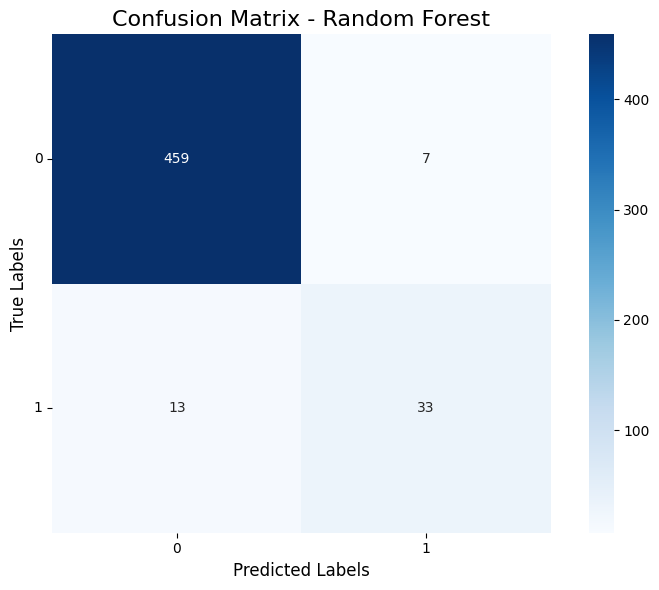

In [43]:
bagging_conf_matrix = confusion_matrix(y_test, y_pred_Bagging)
plot_confusion_matrix(
    y_true=y_test,
    y_pred=y_pred_Bagging,
    labels=[0, 1],  # Adapter si vous avez plus de classes
    normalize=False,  # Mettre True si vous voulez des proportions
    title="Confusion Matrix - Random Forest"
)

In [44]:
y_pred_adaboost = adaboost_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred_adaboost))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       466
           1       0.77      0.74      0.76        46

    accuracy                           0.96       512
   macro avg       0.87      0.86      0.87       512
weighted avg       0.96      0.96      0.96       512



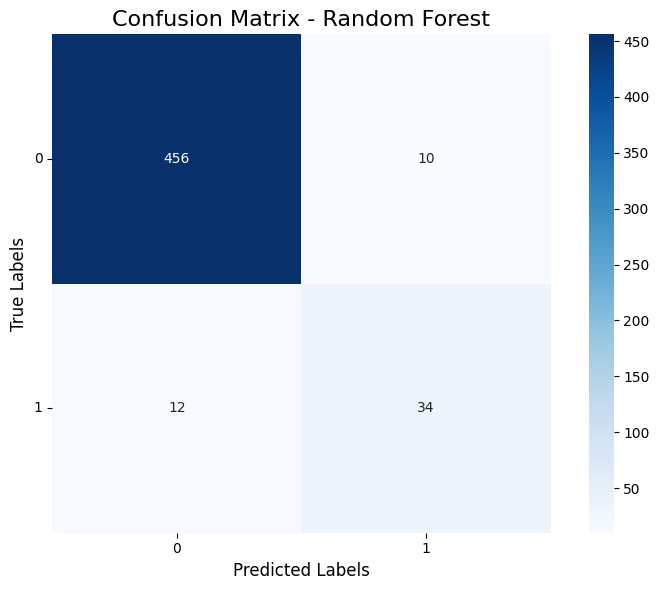

In [45]:
y_pred_adaboost = adaboost_model.predict(X_test)
adaboost_conf_matrix = confusion_matrix(y_test, y_pred_adaboost)
plot_confusion_matrix(
    y_true=y_test,
    y_pred=y_pred_adaboost,
    labels=[0, 1],  # Adapter si vous avez plus de classes
    normalize=False,  # Mettre True si vous voulez des proportions
    title="Confusion Matrix - Random Forest"
)